<a href="https://colab.research.google.com/github/PhatDat09/Sentiment_Analyst_EngData/blob/main/DoAnCoSo_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D,LayerNormalization, Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Data/Test.csv'
data = pd.read_csv(file_path)
data.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [ ]:
sentiment_data = pd.DataFrame({'input': data['text'], 'lable': data['label']})
sentiment_data = sentiment_data.dropna()
sentiment_data = sentiment_data.reset_index(drop=True)
sentiment_data.head()

,input,lable
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [ ]:
input_data = sentiment_data['input'].values
input_lable = sentiment_data['lable'].values

input_pre = []
lable_with_accent = []
for idx , dt in enumerate(input_data):
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
  input_text_pre = " ".join(input_text_pre)
  input_pre.append(input_text_pre)
  lable_with_accent.append(input_lable[idx])

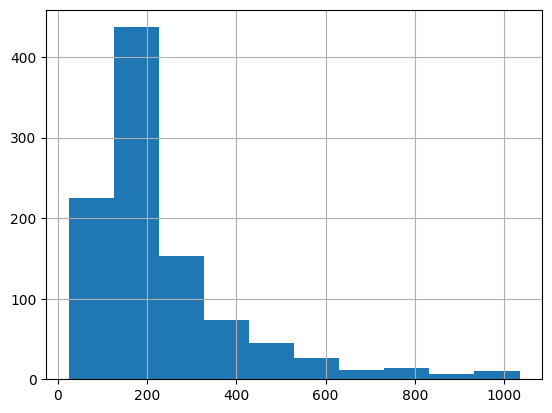

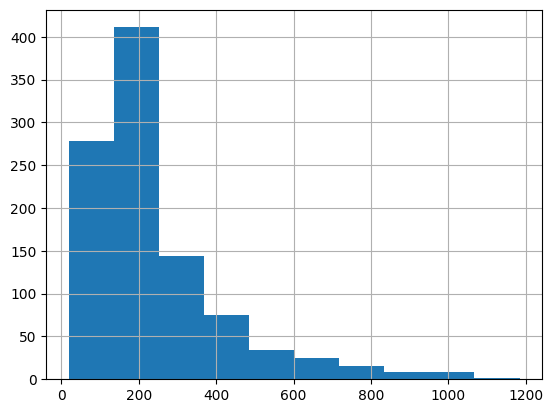

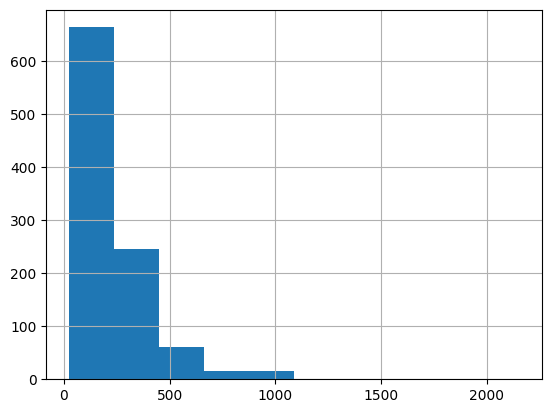

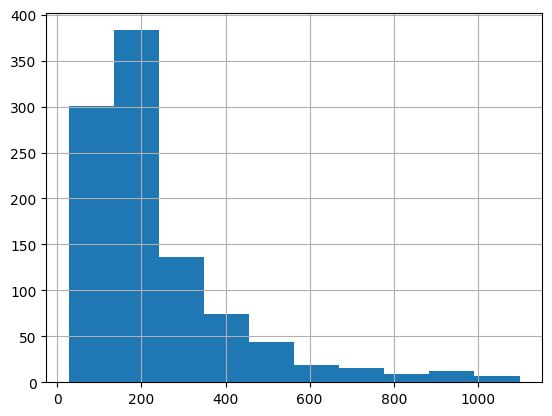

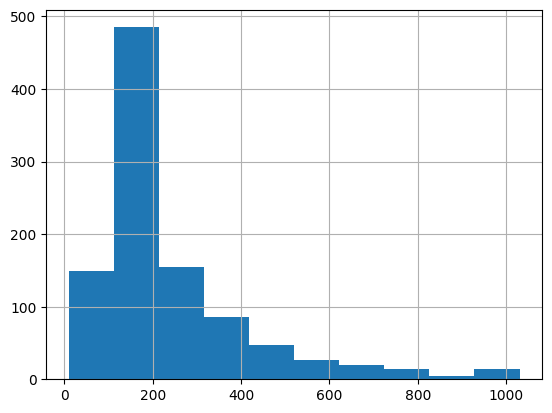

In [ ]:
seq_len = [len(i.split()) for i in input_pre[0:1000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[1000:2000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[2000:3000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[3000:4000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[4000:5000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

In [ ]:

lable_idx = [int(lable) for lable in lable_with_accent]
lable_tf = tf.keras.utils.to_categorical(lable_idx, num_classes= 2, dtype='float32')

tokenizer_data = Tokenizer(oov_token='<00V>', filters = '',split = ' ')
tokenizer_data.fit_on_texts(input_pre)

tokenized_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenized_data_text,padding='post',maxlen=430)

pickle.dump(tokenizer_data, open("tokenizer_data.pkl","wb"))

print("input data.shape ",vec_data.shape)
data_vocab_size = len(tokenizer_data.word_index)+1
print("data_vocab_size: ",data_vocab_size)

X_train, X_val, y_train, y_val = train_test_split(vec_data, lable_tf, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
print("training sample: ",len(X_train))
print("valication sample: ",len(X_val))
print("test sample: ",len(X_test))

input data.shape  (5000, 430)
data_vocab_size:  43603
training sample:  3600
valication sample:  1000
test sample:  400


In [ ]:
def generate_model():
    dropout_threshold = 0.4
    input_dim = data_vocab_size
    output_dim = 32
    input_length = 430
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer="GlorotNormal")(input_layer)

    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(bi_lstm_feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    combine_feature = Concatenate()([cnn_feature, bi_lstm_feature])
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    classifier = Dense(90, activation='relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(70, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(50, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(30, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(2, activation='softmax')(classifier)

    model = Model(inputs=input_layer, outputs=classifier)

    return model

# Giả sử data_vocab_size đã được định nghĩa trước đó
data_vocab_size = 100000

# Tạo mô hình
model = generate_model()

# Biên dịch mô hình
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# In ra cấu trúc mô hình
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 430)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 430, 32)              3200000   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 430, 32)              3104      ['embedding[0][0]']           
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 215, 32)              0         ['conv1d[0][0]']              
 D)                                                                                           

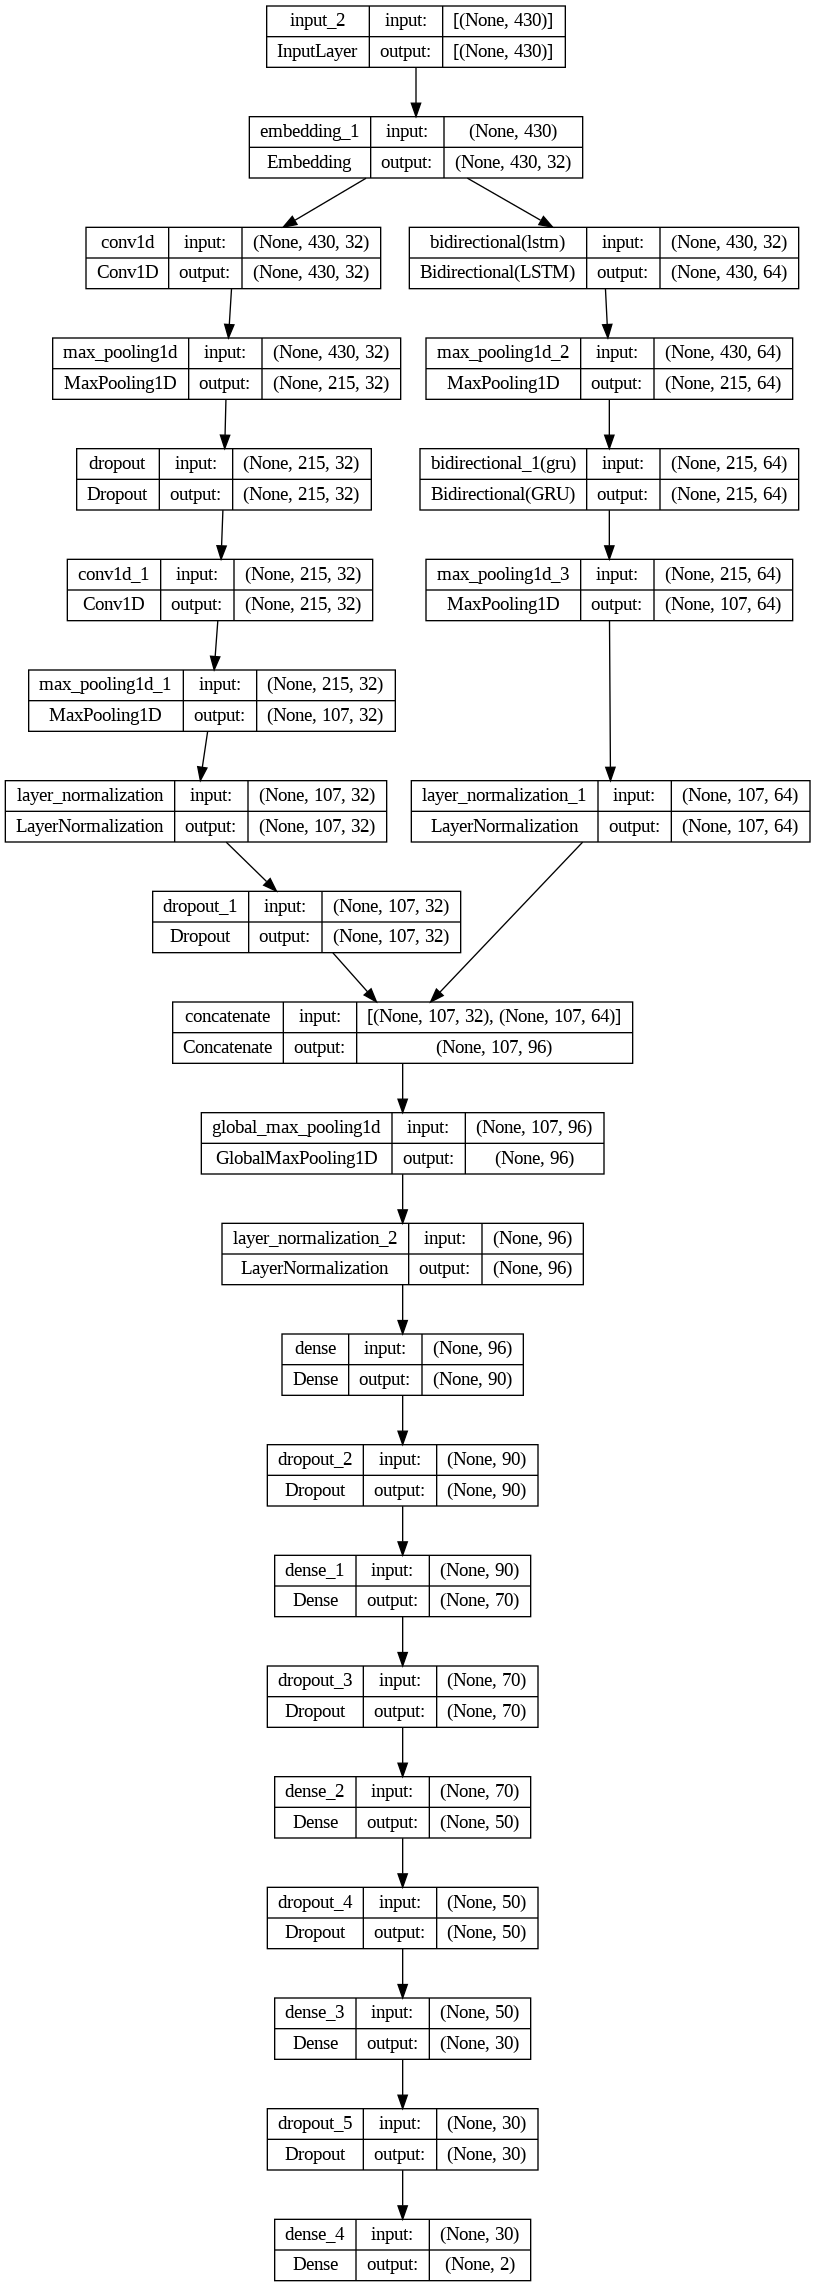

In [ ]:
dot_img_file = 'model_visualize.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.h5',monitor='val_loss')
history = model.fit(x = X_train, y = y_train, validation_data = (X_val,y_val),epochs = 10, batch_size = 128, callbacks = [callback_model] )

Epoch 1/10


In [ ]:
model.load_weights("/content/drive/MyDrive/Data/mohinh_cnn_bstm.h5")
model.evaluate(X_test,y_test)

13/13 [==============================] - 7s 123ms/step - loss: 0.4788 - accuracy: 0.8100


[0.47884345054626465, 0.8100000023841858]

In [ ]:
def preprocess_raw_input(raw_input,tokenizer):
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
  input_text_pre = " ".join(input_text_pre)
  print("Text preprocesse:", input_text_pre)
  tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre])
  vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen = 430)
  return vec_data

def inference_model(input_feature, model):
  output = model(input_feature).numpy()[0]
  result = output.argmax()
  conf = float(output.max())
  lable_dict =  {'negative':0,'positive':1}
  lable = list(lable_dict.keys())
  return lable[int(result)],conf

def prediction(raw_input, tokenizer, model):
  input_model = preprocess_raw_input(raw_input, tokenizer_data)
  result, conf = inference_model(input_model, model)

  return result, conf

my_model = generate_model()
my_model = load_model('/content/drive/MyDrive/Data/mohinh_cnn_bstm.h5')

with open(r'/content/drive/MyDrive/Data/tokenizer_data.pkl',"rb") as input_file:
  my_tokenizer = pickle.load(input_file)

print(prediction("this product is so delicious", my_tokenizer, my_model))
print(prediction("oh my god, i felt headache when i ate food lastday", my_tokenizer, my_model))

Text preprocesse: this product is so delicious
('positive', 0.9979879856109619)
Text preprocesse: oh my god i felt headache when i ate food lastday
('negative', 0.9800726175308228)


In [ ]:
while(True):
    text = input()
    if text == "end":
      break
    else: print(prediction(text, my_tokenizer, my_model)[0] + "\n")

Text preprocesse: this food is so bad it smells so horrible i can't stomach this
negative

Text preprocesse: this product is so delicious
negative

